## Private Market Risk Management

In [16]:
# Imports
%load_ext autoreload
%autoreload 2
%matplotlib inline
from utilities import get_hfi_returns, var_historic, cvar_historic, var_gaussian
import pandas as pd

`get_hfi_returns` calculates the monthly returns of different hedge fund strategies from Jan 1970 to Nov 2018
We are going to use this data to calculate our different risk management measures

In [5]:
hfi = get_hfi_returns()

hfi.head()

,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
1997-01,0.0119,0.0393,0.0178,0.0791,0.0189,0.0213,0.0191,0.0573,0.0281,0.0150,0.0180,-0.0166,0.0317
1997-02,0.0123,0.0298,0.0122,0.0525,0.0101,0.0084,0.0122,0.0175,-0.0006,0.0034,0.0118,0.0426,0.0106
1997-03,0.0078,-0.0021,-0.0012,-0.0120,0.0016,-0.0023,0.0109,-0.0119,-0.0084,0.0060,0.0010,0.0778,-0.0077
1997-04,0.0086,-0.0170,0.0030,0.0119,0.0119,-0.0005,0.0130,0.0172,0.0084,-0.0001,0.0122,-0.0129,0.0009
1997-05,0.0156,-0.0015,0.0233,0.0315,0.0189,0.0346,0.0118,0.0108,0.0394,0.0197,0.0173,-0.0737,0.0275


#### VaR using Historical Simulation

To compute the historic VaR at a certain level, say 5%, all we have to do is to find the number such that 5% of the returns fall below that number and 95% of the returns fall above that number. In other words, we want the 5 percentile return.

In [7]:
# 1% VaR
var_historic(hfi, level=1)

Convertible Arbitrage     0.031776
CTA Global                0.049542
Distressed Securities     0.046654
Emerging Markets          0.088466
Equity Market Neutral     0.018000
Event Driven              0.048612
Fixed Income Arbitrage    0.041672
Global Macro              0.024316
Long/Short Equity         0.049558
Merger Arbitrage          0.025336
Relative Value            0.026660
Short Selling             0.113576
Funds Of Funds            0.039664
dtype: float64

### Conditional VaR using Historical Simulation

In [12]:
# 5% CVaR, 5% is the default value for level
cvar_historic(hfi).sort_values(ascending=False)

Short Selling             0.009873
CTA Global                0.001510
Global Macro              0.000065
Fixed Income Arbitrage   -0.000380
Emerging Markets         -0.001028
Relative Value           -0.001211
Funds Of Funds           -0.001228
Merger Arbitrage         -0.001469
Equity Market Neutral    -0.001603
Convertible Arbitrage    -0.001672
Distressed Securities    -0.001871
Long/Short Equity        -0.002061
Event Driven             -0.003557
dtype: float64

### Gaussian VAR

The idea behind this is very simple. If a set of returns is normally distributed, we know, for instance, that 50% of the returns are below the mean and 50% are above.

We also know that approx two thirds of the returns lie within 1 standard deviation. That means one third lie beyond one standard deviation from the mean. Since the normal distribution is symmetric, approximately one sixth (approx 16%) lie below one standard deviation away from the mean. Therefore, if we know the mean and standard deviation and if we assume that the returns are normally distributed, the 16% VaR would be the mean minus one standard deviation.

In general we can always convert a percentile point to a z-score (which is the number of standard deviations away from the mean that a number is). Therefore, if we can convert the VaR level (such as 1% or 5%) to a z-score, we can calculate the return level where that percent of returns lie below it.


In [14]:
var_gaussian(hfi)

Convertible Arbitrage     0.021691
CTA Global                0.034235
Distressed Securities     0.021032
Emerging Markets          0.047164
Equity Market Neutral     0.008850
Event Driven              0.021144
Fixed Income Arbitrage    0.014579
Global Macro              0.018766
Long/Short Equity         0.026397
Merger Arbitrage          0.010435
Relative Value            0.013061
Short Selling             0.080086
Funds Of Funds            0.021292
dtype: float64

### Cornish-Fisher VaR

The Cornish-Fisher modification is an elegant and simple adjustment.

The z-score tells us how many standard deviations away from the mean we need to go to find the VaR. If the returns arent normal, we know that z-score will give us an inaccurate number. The basic idea is that since we can observe the skewness and kurtosis of the data, we can adjust the z-score up or down to come up with a modifed z-score. e.g. intuitively, all other things being equal, if the skewness is negative, we'll decrease the z-score further down, and if the skewness is positive, we'll push it up.

The adjusted z-score which we'll call $z_{cornishfisher}$ given by:

$$ z_{cornishfisher} = z +\frac{1}{6}(z^2-1)S + \frac{1}{24}(z^3-3z)(K-3)-\frac{1}{36}(2z^3-5z)S^2 $$


In [15]:
var_gaussian(hfi, modified=True)

Convertible Arbitrage     0.025166
CTA Global                0.033094
Distressed Securities     0.025102
Emerging Markets          0.053011
Equity Market Neutral     0.010734
Event Driven              0.025516
Fixed Income Arbitrage    0.017881
Global Macro              0.013581
Long/Short Equity         0.027935
Merger Arbitrage          0.012612
Relative Value            0.016157
Short Selling             0.066157
Funds Of Funds            0.021576
dtype: float64

### Plotting the 3 different VaR

<AxesSubplot:title={'center':'Hedge Fund Indices: VaR at 5%'}>

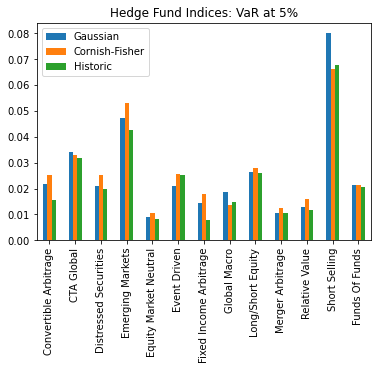

In [17]:
var_table = [var_gaussian(hfi), 
             var_gaussian(hfi, modified=True), 
             var_historic(hfi)]
comparison = pd.concat(var_table, axis=1)
comparison.columns=['Gaussian', 'Cornish-Fisher', 'Historic']
comparison.plot.bar(title="Hedge Fund Indices: VaR at 5%")


## Mean Variance Optimization

The objective of Mean-Variance Optimization is to find the portfolio with the lowest volatility (as measured by standard deviation of returns) given a target return or the porfolio with the maximum return given a target volatility.
In this notebook we are going to identify our optimal portfolio on the efficient frontier ( graph that plots the returns given different level of volatilities).

The dataset used will be the monthly returns of different industries in the SP500 from `1926-2018`

In [42]:

from utilities import get_ind_returns, annualize_rets, plot_ef

ind = get_ind_returns() # monthly returns of industries in the SP500
er = annualize_rets(ind["2000":"2018"], 12) # Annual return from 2000-2018
cov = ind["2000":"2018"].cov() # Covariance of returns

### Efficient Frontier for a portfolio including the following indexes
`["Smoke", "Fin", "Games", "Coal"]`

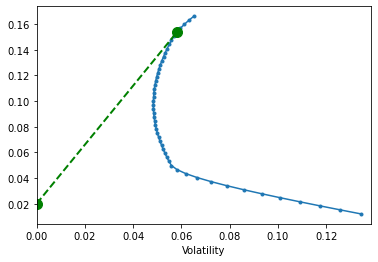

In [26]:
l = l = ["Smoke", "Fin", "Games", "Coal"]
plot_ef(n_points=50, er=er[l], cov=cov.loc[l,l], show_cml=True, riskfree_rate=0.02);

Although the promise of the Markowitz procedure is exciting, it tends to fall apart in practice. The problem is that we rarely know Expected Returns and Expected Covariance in advance. Our estimates almost certainly contain some estimation error, and we'll see that the procedure is highly sensitive to these errors, which tend to get exaggerated in the portfolio.

In [38]:
l = ["Food", "Steel"]
from utilities import msr
import numpy as np

er_ii = annualize_rets(ind["1996":"2000"], 12)
cov_ii = ind["1996":"2000"].cov()
#Maximum Sharpe ratio portfolio
weights = msr(riskfree_rate=0.02, er=np.array(er_ii[l]), cov=cov_ii.loc[l,l])

print(f" Weights : {weights} \nand returns: {er[l]}")

 Weights : [0.74028066 0.25971934] 
and returns: Food     0.116799
Steel    0.115809
dtype: float64


Now assume that we had a really good estimator, and we were off by only a fraction of a percent in our estimate, and we had estimated a return of 11 and 12 percent respectively for Food and Steel

In [39]:
msr(0.1, np.array([.11, .12]), cov_ii.loc[l,l])

array([0.57930354, 0.42069646])

We see that even a small change in the estimate causes a major change in the weights. What if we were off by around 1% to 2% percent in each estimate and estimated 10% and 13% instead of the return of 11.6% and 11.5%?

In [40]:
msr(0.1, np.array([.10, .13]), cov_ii.loc[l,l])

array([0., 1.])

And if we had made the _same_ estimation error, but the error went the other way (13% and 10%)?

In [41]:
msr(0.1, np.array([.13, .1]), cov_ii.loc[l,l])

array([1., 0.])

One way to avoid this estimation game is to skip the entire process and just rely on _naive_ diversification, which means hold all stocks with equal weight. Researchers have shown that the EW portfolio is a remarkably good portfolio to hold. In fact, there is overwhelming siupport for the idea that it is a far better portfolio to hold than a cap-weighted equivalent.

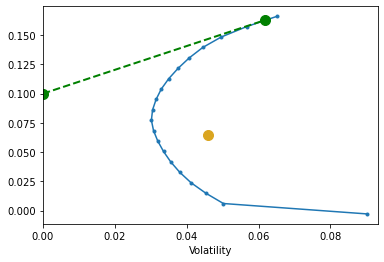

In [43]:
plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1, show_ew=True)

The EW portfolio is far inside the efficient frontier, but it requires no estimation whatsoever.

#### Global Minimum Variance (GMV) Portfolio

However, there is another point on the efficient frontier that is very interesting. This is the _nose_ of the hull, which is the portfolio of lowest volatility across all possible portfolios. This is called the Minimum Volatility or the Global Minimum Volatility or GMV portfolio.

<AxesSubplot:xlabel='Volatility'>

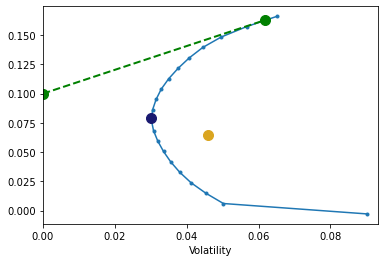

In [44]:
plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1, show_ew=True, show_gmv=True)

### Further Research

We could use the black litterman model instead of the MVO.
 the Black–Litterman model is a mathematical model for portfolio allocation developed in 1990 at Goldman Sachs by Fischer Black and Robert Litterman, and published in 1992. It seeks to overcome problems that institutional investors have encountered in applying modern portfolio theory in practice

## Monte-Carlo Simulations

Application of MC simulation to calculate the price of a put option

In [45]:
import numpy as np
from scipy.stats import norm
from scipy.stats import uniform
import matplotlib.pyplot as plt
import math
import random

Text(0, 0.5, 'Put Value')

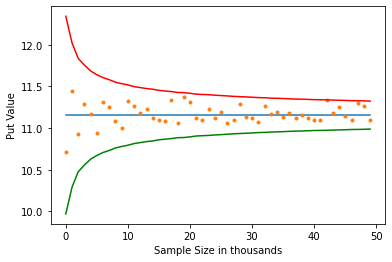

In [47]:
#Code for the put option
random.seed(0)

#Share information
sigma = 0.3
r = 0.1
S0 = 100

#Option information
T = 0.5
K = 110

#Function for terminal share valuation
def terminal_shareprice(S_0, risk_free_rate,sigma,Z,T):
    """Generates the terminal share price given some random normal values, Z"""
    return S_0*np.exp((risk_free_rate-sigma**2/2)*T+sigma*np.sqrt(T)*Z)

#Function for put valuations
def put_price(S_0,K,risk_free_rate,sigma,Z,T):
    """Function for evaluating the call price in Monte Carlo Estimation"""
    share_terminal = terminal_shareprice(S_0, risk_free_rate, sigma, Z, T)
    return np.exp(-risk_free_rate*T)*np.maximum(K-share_terminal,0)

#Empty vectors to be filled later
mput_estimates = [None]*50
mput_std = [None]*50

#Applying MC estimation
for i in range(1,51):
    norm_array = norm.rvs(size = 1000*i)
    mput_val = put_price(S0,K,r,sigma,norm_array,T)
    mput_estimates[i-1] = np.mean(mput_val)
    mput_std[i-1] = np.std(mput_val)/np.sqrt(1000*i)
    
#Determining the analytical solution
d_1 = (math.log(S0/K)+(r + sigma**2/2)*T)/(sigma*math.sqrt(T))
d_2 = d_1 - sigma*math.sqrt(T)
mput_analytic = K*math.exp(-r*T)*norm.cdf(-d_2)-S0*norm.cdf(-d_1)

#Plotting the graph
plt.plot([mput_analytic]*50)
plt.plot(mput_estimates,'.')
plt.plot(mput_analytic+np.array(mput_std)*3, 'r')
plt.plot(mput_analytic-np.array(mput_std)*3, 'g')
plt.xlabel("Sample Size in thousands")

plt.ylabel("Put Value")